In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
MAX_BATCH_SIZE = 9
GPUS = 32
ORG_NAME = "DEAD FoundationsDAO"
SPLITS_FREQ = "2d"
LAST_FOLDS = 20
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-11-28"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29681 entries, 0 to 29680
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 29681 non-null  object        
 1   author             29681 non-null  object        
 2   date               29681 non-null  datetime64[us]
 3   start              29681 non-null  datetime64[us]
 4   end                5799 non-null   datetime64[us]
 5   platform_proposal  29681 non-null  object        
 6   title              29681 non-null  object        
 7   description        4637 non-null   object        
dtypes: datetime64[us](3), object(5)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        17738 non-null  object        
 1   proposal  17738 non-null  o

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,9b0951e8-192b-5b68-8e1a-1b392e5b704f,2020-11-25 14:31:40,1
1,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,9903573c-d495-5c45-8209-c16ac4527667,2020-11-25 14:34:40,1
2,0xa3564677fc4907a15c9a7eae1dbc1ae9ac57b8e1,83846b14-c310-5c84-a229-f8f88747a417,2020-12-04 01:16:40,1
3,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,83846b14-c310-5c84-a229-f8f88747a417,2020-12-04 01:41:40,1
4,0xa3564677fc4907a15c9a7eae1dbc1ae9ac57b8e1,e5b05bac-ebea-5d63-b09c-6721cb6c3b65,2020-12-05 00:14:50,1
...,...,...,...,...
17733,0x96e852000ec69fd7f1b5a552cb58a9d24f76e2c6,0d403a5d-a7ff-50ae-b3e9-7ab8020241eb,2022-06-28 08:18:00,1
17734,0x96e852000ec69fd7f1b5a552cb58a9d24f76e2c6,992cb72b-046d-55d8-81d0-f1e3f664c86a,2022-06-28 08:18:15,1
17735,0x96e852000ec69fd7f1b5a552cb58a9d24f76e2c6,6c40609b-866f-588e-947f-ae832a9e9af2,2022-06-28 08:18:30,1
17736,0x96e852000ec69fd7f1b5a552cb58a9d24f76e2c6,f4a42b8c-ee15-551f-8e65-86b17a237863,2022-06-28 08:19:45,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-23 00:00:00'),
 Timestamp('2021-10-25 00:00:00'),
 Timestamp('2021-10-27 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-02 00:00:00'),
 Timestamp('2021-11-04 00:00:00'),
 Timestamp('2021-11-06 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-12 00:00:00'),
 Timestamp('2021-11-14 00:00:00'),
 Timestamp('2021-11-16 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-22 00:00:00'),
 Timestamp('2021-11-24 00:00:00'),
 Timestamp('2021-11-26 00:00:00'),
 Timestamp('2021-11-28 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/DEAD FoundationsDAO/hparams-pln-similarity_2d_normalize.pkl with 560 results


  0%|          | 0/560 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2021-10-21,all-mpnet-base-v2,7d,0.080626,0.001233,2,1.000000,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.121717
1,2021-10-21,all-mpnet-base-v2,14d,0.228874,0.001227,2,1.000000,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.119298
2,2021-10-21,all-mpnet-base-v2,21d,0.234370,0.001238,3,0.666667,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.121496
3,2021-10-21,all-mpnet-base-v2,30d,0.080853,0.001165,3,1.000000,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.120660
4,2021-10-21,all-mpnet-base-v2,60d,0.234818,0.001214,4,1.000000,0.333333,0.200000,0.100000,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.118915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2021-11-28,all-MiniLM-L6-v2,21d,0.598736,0.003144,35,0.028571,0.038095,0.022857,0.034286,...,0.122555,0.234813,1.0,1.0,0.562500,0.562500,0.402027,0.461712,0.506757,0.172804
556,2021-11-28,all-MiniLM-L6-v2,30d,0.939442,0.004505,77,0.012987,0.025974,0.015584,0.022078,...,0.094668,0.155435,1.0,1.0,0.541667,0.541667,0.426520,0.471284,0.505068,0.218537
557,2021-11-28,all-MiniLM-L6-v2,60d,1.327568,0.004969,80,0.012500,0.020833,0.012500,0.020000,...,0.078618,0.124606,1.0,1.0,0.541667,0.541667,0.426520,0.471284,0.505068,0.218941
558,2021-11-28,all-MiniLM-L6-v2,90d,1.329529,0.005018,80,0.012500,0.020833,0.012500,0.020000,...,0.078618,0.124606,1.0,1.0,0.541667,0.541667,0.426520,0.471284,0.505068,0.221051


<Axes: xlabel='window_size', ylabel='map@10'>

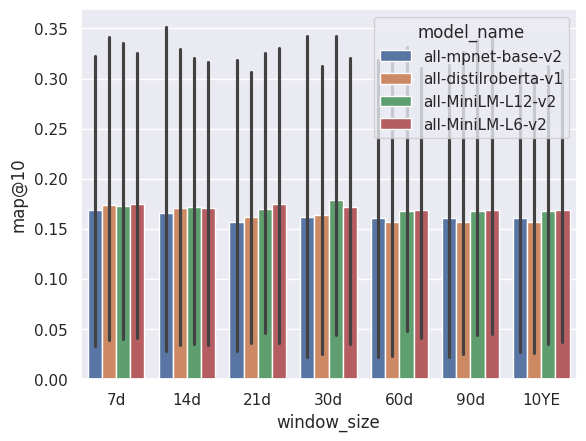

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
window_size,model_name,,,,,,,,,,,,,,,,
21d,all-MiniLM-L12-v2,0.476954,0.047458,0.040117,0.018131,0.123504,0.142468,0.204815,0.126540,0.135217,0.148558,0.149697,0.209041,0.553029,0.358965,0.345097,0.506130
30d,all-MiniLM-L12-v2,0.611605,0.046887,0.038291,0.017260,0.127649,0.147045,0.222127,0.126905,0.134971,0.148492,0.153097,0.205901,0.561611,0.357587,0.342466,0.506130
90d,all-MiniLM-L6-v2,0.644404,0.046838,0.034350,0.016688,0.140935,0.150206,0.225031,0.126888,0.131224,0.144725,0.157318,0.180633,0.526666,0.361498,0.345733,0.501412
60d,all-MiniLM-L6-v2,0.620275,0.046838,0.034350,0.016693,0.140935,0.150206,0.225116,0.126888,0.131224,0.144745,0.157318,0.180633,0.526904,0.361498,0.345733,0.501412
10YE,all-MiniLM-L6-v2,0.643739,0.046815,0.034261,0.016672,0.140892,0.150034,0.225003,0.126840,0.131103,0.144621,0.157146,0.180269,0.526544,0.357660,0.343875,0.498578
21d,all-MiniLM-L6-v2,0.485314,0.047373,0.035658,0.017609,0.123111,0.131758,0.194186,0.126783,0.131100,0.144455,0.154953,0.179748,0.518004,0.363722,0.348589,0.500382
7d,all-MiniLM-L6-v2,0.268253,0.051375,0.043707,0.025303,0.084240,0.092429,0.133078,0.125778,0.131051,0.143553,0.134264,0.163570,0.471238,0.325727,0.343219,0.537119
60d,all-MiniLM-L12-v2,0.660222,0.044350,0.035748,0.016855,0.135860,0.154966,0.231332,0.123330,0.130986,0.145000,0.146735,0.200322,0.554117,0.361256,0.343605,0.506735
90d,all-MiniLM-L12-v2,0.637550,0.044350,0.035616,0.016865,0.135860,0.154806,0.231436,0.123330,0.130930,0.144994,0.146735,0.199993,0.554623,0.361256,0.343605,0.506735


In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/models/plnsim-best-avg_2d_normalize.parquet


/tmp/ipykernel_3808705/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2021-10-21,21d,all-MiniLM-L12-v2,0.220809,0.001179,3,0.666667,0.333333,0.200000,0.100000,0.066667,0.010000,0.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.121097
2021-10-23,21d,all-MiniLM-L12-v2,0.067349,0.001085,3,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,0.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.117375
2021-10-25,21d,all-MiniLM-L12-v2,0.221788,0.001207,5,0.800000,0.333333,0.200000,0.100000,0.066667,0.010000,0.800000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.120028
2021-10-27,21d,all-MiniLM-L12-v2,0.222784,0.003127,8,0.000000,0.041667,0.075000,0.100000,0.083333,0.072500,0.000000,...,0.046966,0.048151,0.255572,0.000000,0.007812,0.006276,0.021197,0.025937,0.155621,0.161750
2021-10-29,21d,all-MiniLM-L12-v2,0.135633,0.003901,15,0.000000,0.000000,0.000000,0.000000,0.000000,0.003333,0.000000,...,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.131075
2021-10-31,21d,all-MiniLM-L12-v2,0.437212,0.004465,68,0.029412,0.019608,0.020588,0.014706,0.014706,0.006765,0.029412,...,0.060924,0.081519,0.261294,0.291667,0.361111,0.361111,0.306548,0.306548,0.306548,0.231324
2021-11-02,21d,all-MiniLM-L12-v2,0.394672,0.003417,14,0.214286,0.071429,0.071429,0.064286,0.052381,0.017143,0.214286,...,0.097789,0.119898,0.469388,0.144841,0.144841,0.255952,0.297619,0.297619,0.297619,0.165589
2021-11-04,21d,all-MiniLM-L12-v2,0.598097,0.002965,20,0.000000,0.016667,0.030000,0.035000,0.030000,0.015500,0.000000,...,0.116667,0.175000,1.000000,0.000000,0.166667,0.500000,0.500000,0.500000,0.500000,0.142201
2021-11-06,21d,all-MiniLM-L12-v2,0.610615,0.002915,18,0.000000,0.037037,0.033333,0.044444,0.037037,0.017778,0.000000,...,0.166667,0.185185,1.000000,0.000000,0.250000,0.333333,0.333333,0.333333,0.333333,0.131434


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/models/plnsim-best-val_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-10-21,all-mpnet-base-v2,7d,0.080626,0.200000,0.100000,0.010000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-10-23,all-mpnet-base-v2,7d,0.233115,0.200000,0.100000,0.010000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-10-25,all-MiniLM-L12-v2,10YE,0.219433,0.200000,0.100000,0.010000,0.900000,0.900000,0.900000,0.866667,0.866667,0.866667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-10-27,all-distilroberta-v1,21d,0.241532,0.150000,0.125000,0.073750,0.188219,0.183421,0.172348,0.131667,0.114063,0.088607,0.128730,0.139609,0.224752,0.014922,0.038958,0.132671
2021-10-29,all-distilroberta-v1,10YE,0.159803,0.000000,0.006667,0.002667,0.000000,0.004417,0.012215,0.000000,0.000741,0.001875,0.000000,0.006667,0.026667,0.000000,0.100000,0.100000
2021-10-31,all-MiniLM-L12-v2,10YE,0.290418,0.020588,0.014706,0.006765,0.036437,0.043134,0.094246,0.023039,0.025228,0.034139,0.047794,0.060924,0.261294,0.361111,0.306548,0.306548
2021-11-02,all-MiniLM-L6-v2,10YE,0.558775,0.071429,0.071429,0.017143,0.097334,0.114061,0.205828,0.065714,0.077367,0.096373,0.054847,0.109694,0.469388,0.255952,0.297619,0.297619
2021-11-04,all-distilroberta-v1,7d,0.396638,0.031579,0.047368,0.015789,0.022343,0.073926,0.217260,0.015088,0.043933,0.062813,0.026316,0.184211,1.000000,0.500000,0.666667,0.666667
2021-11-06,all-distilroberta-v1,7d,0.456021,0.071429,0.064286,0.020000,0.063657,0.087873,0.237527,0.043452,0.066610,0.111053,0.107143,0.178571,1.000000,0.333333,0.333333,0.333333


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.318101,0.071044,0.052508,0.023805,0.139391,0.149223,0.186501,0.189768,0.194626,0.204292,0.213704,0.250178,0.531075,0.406686,0.400111,0.532325
std,0.154250,0.064809,0.032563,0.018893,0.234187,0.230157,0.220863,0.333729,0.331295,0.327446,0.353506,0.339978,0.361972,0.351722,0.318727,0.288892
min,0.080626,0.000000,0.006667,0.002667,0.000000,0.004417,0.012215,0.000000,0.000741,0.001875,0.000000,0.006667,0.026667,0.000000,0.036643,0.100000
25%,0.213694,0.031377,0.029327,0.010000,0.020065,0.023358,0.041255,0.031868,0.042426,0.050005,0.022758,0.045824,0.252158,0.093579,0.113095,0.326637
50%,0.269403,0.046496,0.044153,0.018571,0.029636,0.045553,0.105629,0.051003,0.058321,0.062479,0.048376,0.124652,0.350132,0.347222,0.340864,0.462938
75%,0.411483,0.078571,0.066071,0.034638,0.120055,0.131401,0.222327,0.086542,0.086541,0.114247,0.134241,0.197077,1.000000,0.525225,0.550450,0.706140
max,0.620998,0.200000,0.125000,0.073750,0.900000,0.900000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DEAD FoundationsDAO/models/plnsim-best-test_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2021-10-23,all-mpnet-base-v2,7d,0.233115,0.200000,0.100000,0.010000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-10-25,all-mpnet-base-v2,7d,0.083477,0.200000,0.100000,0.010000,0.700000,0.700000,0.700000,0.833333,0.833333,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-10-27,all-MiniLM-L12-v2,10YE,0.073127,0.050000,0.062500,0.067500,0.046461,0.064821,0.124244,0.018750,0.023467,0.031914,0.042643,0.045189,0.260943,0.007812,0.014088,0.143772
2021-10-29,all-distilroberta-v1,21d,0.305996,0.000000,0.006667,0.002667,0.000000,0.004417,0.012215,0.000000,0.000741,0.001875,0.000000,0.006667,0.026667,0.000000,0.100000,0.100000
2021-10-31,all-distilroberta-v1,10YE,0.469959,0.011765,0.008824,0.003676,0.013941,0.018241,0.040868,0.006985,0.008211,0.012128,0.021324,0.031127,0.111532,0.350000,0.288889,0.288889
2021-11-02,all-MiniLM-L12-v2,10YE,0.561644,0.071429,0.064286,0.017143,0.092482,0.102269,0.199886,0.058571,0.061139,0.086031,0.054847,0.097789,0.469388,0.255952,0.297619,0.297619
2021-11-04,all-MiniLM-L6-v2,10YE,0.448588,0.030000,0.040000,0.015500,0.022343,0.060142,0.232850,0.014333,0.038730,0.066386,0.025000,0.125000,1.000000,0.500000,0.666667,0.666667
2021-11-06,all-distilroberta-v1,7d,0.456021,0.071429,0.064286,0.020000,0.063657,0.087873,0.237527,0.043452,0.066610,0.111053,0.107143,0.178571,1.000000,0.333333,0.333333,0.333333
2021-11-08,all-distilroberta-v1,7d,0.172702,0.041379,0.041379,0.036552,0.023565,0.027896,0.051664,0.040230,0.040952,0.049817,0.013328,0.037784,0.275495,0.193262,0.214539,0.640071


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.297238,0.050210,0.041777,0.024528,0.085044,0.092609,0.139418,0.123351,0.127350,0.141784,0.129961,0.159528,0.497177,0.331101,0.353301,0.546490
std,0.145043,0.056234,0.027927,0.018624,0.185774,0.183865,0.179731,0.281350,0.280025,0.275742,0.307875,0.300348,0.359033,0.344058,0.339478,0.293467
min,0.073127,0.000000,0.004348,0.002667,0.000000,0.004417,0.012215,0.000000,0.000741,0.001875,0.000000,0.006333,0.026667,0.000000,0.014088,0.100000
25%,0.179678,0.021295,0.023859,0.010000,0.012604,0.015888,0.036178,0.018643,0.026157,0.034944,0.002148,0.029248,0.229216,0.047775,0.087902,0.293254
50%,0.305996,0.031250,0.040000,0.020000,0.019231,0.021557,0.052268,0.036207,0.038730,0.049817,0.021324,0.043478,0.393459,0.255952,0.288889,0.483957
75%,0.417744,0.051316,0.057566,0.037931,0.036553,0.062482,0.162065,0.043465,0.048453,0.082009,0.049163,0.130416,0.963675,0.485043,0.487179,0.784749
max,0.561644,0.200000,0.100000,0.067500,0.700000,0.700000,0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
